In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.ndimage import gaussian_filter
from skimage.exposure import match_histograms
import re

class SimInputGenerator():
    def __init__(self, fn_origin, tot_time, source_bounds, laser_bounds, time_bounds, num_sources):
        self.origin = fn_origin
        self.source_bounds = source_bounds
        self.laser_bounds = laser_bounds
        self.time_bounds = time_bounds
        self.num_sources = num_sources
        self.time = np.linspace(0,tot_time,num_sources,endpoint=False)
        self.time = np.sort(np.concatenate([self.time, [self.time[1] - 0.0002], self.time[1:] - 0.0001, [tot_time]]))
        return
    
    def generate_mass_flows(self, level_1, level_2):
        time = self.time
        #offset parameters
        signal1_offset = -1.2
        signal2_offset = -1.1
        #rise parameters
        tau_rise = 0.88
        del_rise = 1.54 + signal1_offset
        #drop parameters
        tau_drop = 0.4
        del_drop = 1.44 + signal2_offset
        time_sample = np.linspace(0,time[-1],5000)
        drop_ind = (np.abs(time_sample - del_drop)).argmin()
        rise_ind = (np.abs(time_sample - del_rise)).argmin()
        if level_1 < level_2:
            mat_A_sample = np.exp(-((time_sample - del_rise)/tau_rise))*level_1 + (1 - np.exp(-((time_sample - del_rise)/tau_rise)))*level_2
            mat_A_sample[:rise_ind] = level_1
            mat_B_sample = np.exp(-((time_sample-del_drop)/tau_drop))*(1-level_1) + (1 - np.exp(-((time_sample-del_drop)/tau_drop)))*(1-level_2)
            mat_B_sample[:drop_ind] = (1-level_1)
        else:
            mat_A_sample = np.exp(-((time_sample-del_drop)/tau_drop))*level_1 + (1 - np.exp(-((time_sample-del_drop)/tau_drop)))*level_2
            mat_A_sample[:drop_ind] = level_1
            mat_B_sample = np.exp(-((time_sample-del_rise)/tau_rise))*(1-level_1) + (1 - np.exp(-((time_sample-del_rise)/tau_rise)))*(1-level_2)
            mat_B_sample[:rise_ind] = (1-level_1)

        sample_ind = np.zeros(len(time),dtype=int)
        for i in range(len(time)):
            sample_ind[i] = (np.abs(time[i] - time_sample)).argmin()

        mat_A = mat_A_sample[sample_ind]
        mat_B = mat_B_sample[sample_ind]
        return mat_A, mat_B

    def generate_sources_lines(self, ratio_start, ratio_end, total_mass_flow):
        mat_A, mat_B = self.generate_mass_flows(ratio_start, ratio_end)
        preamble = [f"    ippkt={self.num_sources},\n"]

        mass_flow = (mat_A+mat_B)*total_mass_flow
        total_lines = preamble
        total_source = self.num_sources
        for source_i in range(1,total_source+1):
            body_i = [f"    remark='!! Particle Source {source_i}',",
                      f"    ParticleSourceName({source_i})='Source{source_i}', remark='Particle Source Name',",
                      f"    if_psource_enabled({source_i})=1,",
                      f"    xppl({source_i})=-0.00617, remark='X low',",
                      f"    xppr({source_i})=-0.00583, remark='X high',",
                      f"    yppf({source_i})=-0.00017, remark='Y low',",
                      f"    yppbk({source_i})=0.00017, remark='Y high',",
                      f"    zppb({source_i})=0.003, remark='Z low',",
                      f"    zppt({source_i})=0.0035, remark='Z high',",
                      f"    upp({source_i})=0, remark='X velocity',",
                      f"    vpp({source_i})=0, remark='Y velocity',",
                      f"    wpp({source_i})=-8.19, remark='Z velocity',"]
            mid_line = [f"    isrc_class({source_i})=13, remark='Particle Source Class',",
                        f"    src_temperature({source_i})=300, remark='Initial temperature',"]
            if source_i == 1:
                body_rate_i = [f"    ratet(1,1)={np.round(mass_flow[0],1)},",
                            f"    ratet(3,1)={np.round(mass_flow[2],1)},",
                            f"    ratet(4,1)=0.0,"
                            ] + mid_line + [
                            f"    src_species(1, 1)={np.round(mat_A[0],4)},",
                            f"    src_species(2, 1)={np.round(mat_B[0],4)},",
                            f"    if_psource_linked({source_i})=1,\n"]
            elif source_i == total_source:
                body_rate_i = ["    ratet(1,8)=0.0,",
                            "    ratet(15,8)=0.0,",
                            f"    ratet(16,8)={np.round(mass_flow[2*total_source - 1],2)},",
                            f"    ratet(17,8)={np.round(mass_flow[2*total_source],2)},"
                            ] + mid_line + [
                            f"    src_species(1, 8)={np.round(np.mean((mat_A/(mat_A + mat_B))[(2*total_source - 1):]),4)},",
                            f"    src_species(2, 8)={np.round(np.mean((mat_B/(mat_A + mat_B))[(2*total_source - 1):]),4)},",
                            f"    if_psource_linked({source_i})=1,\n"]
            else:
                body_rate_i = ["    ratet(1,4)=0.0,",
                            f"    ratet({2*source_i - 1},{source_i})=0.0,",
                            f"    ratet({2*source_i},{source_i})={np.round(mass_flow[2*source_i - 1],2)},",
                            f"    ratet({2*source_i + 1},{source_i})={np.round(mass_flow[2*source_i + 1],2)},",
                            f"    ratet({2*(source_i + 1)},{source_i})=0.0,"
                            ] + mid_line + [
                            f"    src_species(1, {source_i})={np.round(np.mean((mat_A/(mat_A + mat_B))[(2*source_i - 1):(2*source_i + 1)]),4)},",
                            f"    src_species(2, {source_i})={np.round(np.mean((mat_B/(mat_A + mat_B))[(2*source_i - 1):(2*source_i + 1)]),4)},",
                            f"    if_psource_linked({source_i})=1,\n"]
            
            total_lines = total_lines + body_i + body_rate_i

        total_lines = total_lines + ["\n"]

        return total_lines

    def generate_time_lines(self):
        total_lines = []
        for time_i in range(1, len(self.time)+1):
            total_lines = total_lines + [f"    tms({time_i})={np.round(self.time[time_i-1],6)},"]
        total_lines[-1] = total_lines[-1] + "\n"
        return total_lines

    def generate_laser_lines(self, laser_power):
        lines = [f"    powlbm(1,1)={np.round(laser_power, 5)},",
                 f"    powlbm(2,1)={np.round(laser_power, 5)},",
                  "    powlbm(3, 1)=0,",
                  "    powlbm(4, 1)=0,"]
        return lines

    def generate_total_lines(self, source_lines, laser_lines, time_lines):
        source_bounds = self.source_bounds
        laser_bounds = self.laser_bounds
        time_bounds = self.time_bounds
        f = open(self.origin,'r')
        replace_section = False
        original_sections = []
        total_file = []
        for line in f:
            if len(line) > 1:
                line = line[:-1]
            
            if replace_section and source_bounds[1] in line:
                replace_section = False
                total_file = total_file + source_lines
            elif replace_section and laser_bounds[1] in line:
                replace_section = False
                total_file = total_file + laser_lines
            elif replace_section and time_bounds[1] in line:
                replace_section = False
                total_file = total_file + time_lines
            
            if not replace_section:
                original_sections = original_sections + [line]
            
            if source_bounds[0] in line or laser_bounds[0] in line or time_bounds[0] in line:
                replace_section = True
                total_file = total_file + original_sections
                original_sections = []

        total_file = total_file + original_sections
        f.close()
        return total_file

    def save_param_file(self, fn, total_lines):
        f = open(fn, "w")
        for i in range(len(total_lines)):
            if len(total_lines[i]) > 1:
                f.write(total_lines[i] + "\n")
            else:
                f.write(total_lines[i])
        f.close()

    def generate_input_file(self, fn_write, ratios, mass_flow, laser_pwr):
        source_lines = self.generate_sources_lines(ratios[0], ratios[1], mass_flow)
        laser_lines = self.generate_laser_lines(laser_pwr)
        time_lines = self.generate_time_lines()
        total_lines = self.generate_total_lines(source_lines, laser_lines, time_lines)
        self.save_param_file(fn_write, total_lines)


class SimRunner():
    def __init__(self):
        return

class SimOutAnalyzer():
    def __init__(self, pixel_size, num_timesteps, num_nodes, num_vars):
        self.pixel_size = pixel_size
        self.timesteps = num_timesteps
        self.nodes = num_nodes
        self.num_vars = num_vars
        return
    
    def virtual_sensor_img(self, arr, mask_ind = 3, num_data = 3, interp_ind = [1,2], sigma = 40):
        pixel_size = self.pixel_size
        mask_metal = arr[:,mask_ind] > 0.1
        metal_only = arr[mask_metal, :]
        unique_2d_pts = np.unique(metal_only[:,:2],axis = 0)
        unique_data_2d = np.zeros((unique_2d_pts.shape[0],num_data))
        for i in range(unique_2d_pts.shape[0]):
            pt_mask = np.nonzero(np.logical_and(metal_only[:,0] == unique_2d_pts[i,0], metal_only[:,1] == unique_2d_pts[i,1]))[0]
            z_i = metal_only[pt_mask, 2]
            max_ind = pt_mask[np.argmax(z_i)]
            unique_data_2d[i,:] = metal_only[max_ind, 3:]
        interp_temp = CloughTocher2DInterpolator(unique_2d_pts,unique_data_2d[:,interp_ind[0]])
        interp_liq = CloughTocher2DInterpolator(unique_2d_pts, unique_data_2d[:,interp_ind[1]])
        x_range = np.abs(unique_2d_pts[:,0].min() - unique_2d_pts[:,0].max()) * 1e4
        y_range = np.abs(unique_2d_pts[:,1].min() - unique_2d_pts[:,1].max()) * 1e4
        x_num = int(x_range/pixel_size)
        y_num = int(y_range/pixel_size)
        X = np.linspace(unique_2d_pts[:,0].min(),unique_2d_pts[:,0].max(), x_num)
        Y = np.linspace(unique_2d_pts[:,1].min(),unique_2d_pts[:,1].max(), y_num)
        X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
        temp_raw = interp_temp(X, Y)
        liquid_raw = interp_liq(X, Y)
        temp_filter = gaussian_filter(temp_raw, sigma)
        liquid = gaussian_filter(liquid_raw, sigma)
        temp = match_histograms(temp_filter, temp_raw)
        return temp, liquid

    def virtual_sensor_load(self, path):
        f = open(path)
        lines = f.readlines()
        f.close()
        rows = len(lines)
        curr_row = 0
        curr_block = -1
        data = -1*np.ones([self.timesteps, self.nodes, self.num_vars])
        times = -1*np.ones(self.timesteps)
        while curr_row < rows:
            line_curr = lines[curr_row]
            if 't=' in line_curr:
                #Determine the time
                curr_block += 1
                match = re.match(r't=([0-9]*\.?[0-9]+)', line_curr.split()[5])
                if match != None:
                    times[curr_block] = float(match.group(1))
                else:
                    print('Time Format Error! Time will not be correct for block ' + str(curr_block))
                
                #Capture the data
                block_data_lines = lines[(curr_row + 3):(curr_row + 3 + self.nodes)]
                for i in range(self.nodes):
                    data[curr_block,i,:] = [float(num) for num in block_data_lines[i].split()]
                curr_row = curr_row + 3 + self.nodes
            else:
                curr_row += 1

        ind_keep = np.nonzero(times != -1)[0]
        times_out = times[ind_keep]
        data_out = data[ind_keep,:,:]
        return times_out, data_out
    
    def calc_height_width(data, criteria = 0.05, start_frame = 0, last_frame = -1, fraction_ind = 3):
        mask = data[last_frame,:,fraction_ind] - data[start_frame,:,fraction_ind] > criteria
        max_width = np.max(data[last_frame, mask, 0]) - np.min(data[last_frame, mask, 0])
        uni_width_nodes = np.unique(data[last_frame,mask,0])
        uni_length_nodes = np.unique(data[last_frame,mask,1])
        uni_height_nodes = np.unique(data[last_frame,mask,2])
        midplane = uni_width_nodes[np.argmin(np.abs(uni_width_nodes - np.min(uni_width_nodes) - max_width/2))]
        mask_data = data[last_frame,mask,:]
        cell_size_height = np.median(np.diff(uni_height_nodes))
        cell_size_width = np.median(np.diff(uni_width_nodes))
        interp_height = np.zeros(len(uni_length_nodes))
        interp_width = np.zeros(len(uni_length_nodes))
        for i in range(len(uni_length_nodes)):
            height_ind = np.nonzero(np.logical_and(mask_data[:,0] == midplane, mask_data[:,1] == uni_length_nodes[i]))[0]
            width_ind = np.nonzero(np.logical_and(mask_data[:,2] == np.min(uni_height_nodes), mask_data[:,1] == uni_length_nodes[i]))[0]
            height_slice = mask_data[height_ind,:]
            width_slice = mask_data[width_ind,:]
            max_height = np.max(height_slice[:,2])
            range_width = [np.min(width_slice[:,0]), np.max(width_slice[:,0])]
            max_height_ind = np.argmax(height_slice[:,2])
            range_width_ind = [np.argmin(width_slice[:,0]), np.argmax(width_slice[:,0])]
            melt_fraction_height = height_slice[max_height_ind,fraction_ind]
            melt_fraction_width = [width_slice[range_width_ind[0],fraction_ind], width_slice[range_width_ind[1],fraction_ind]]
            interp_height[i] = max_height + cell_size_height*(melt_fraction_height - 0.5)
            interp_width[i] = (range_width[1] + cell_size_width*(melt_fraction_width[1] - 0.5)) - (range_width[0] - cell_size_width*(melt_fraction_width[0] - 0.5))
        
        return interp_height, interp_width

    def new_point_finder(ref_points, to_classify, max_find_num = 5, classify_data = None):
        ref_points_norm = ref_points
        ref_points_norm[:,0] = (ref_points_norm[:,0] - 400)/300
        to_classify_norm = to_classify
        to_classify_norm[:,0] = (to_classify_norm[:,0] - 400)/300
        closest_point_dist = np.zeros(len(to_classify[:,0]))
        for i in range(len(to_classify[:,0])):
            distance_to_points = np.linalg.norm(ref_points_norm - to_classify_norm[i,:], axis = 1)
            closest_point_dist[i] = np.min(distance_to_points)

        if classify_data is None:
            classify_data = closest_point_dist
        
        max_point = np.zeros(max_find_num)
        max_point[0] = np.max(classify_data)
        max_var = np.zeros([max_find_num,3])
        max_ind = np.argmax(classify_data)
        max_dist = closest_point_dist[max_ind]
        max_var[0,:] = to_classify_norm[max_ind, :]
        distance_to_max = np.linalg.norm(to_classify_norm - max_var[0,:], axis = 1)
        rest_var_to_classify = to_classify_norm[distance_to_max > max_dist,:]
        rest_data_to_classify = classify_data[distance_to_max > max_dist]
        dist_to_comp = closest_point_dist[distance_to_max > max_dist]
        for i in range(max_find_num - 1):
            max_point[i+1] = np.max(rest_data_to_classify)
            max_ind = np.argmax(rest_data_to_classify)
            max_dist = dist_to_comp[max_ind]
            max_var[i+1,:] = rest_var_to_classify[max_ind,:]
            distance_to_max = np.linalg.norm(rest_var_to_classify - max_var[i+1,:], axis = 1)
            rest_var_to_classify = rest_var_to_classify[distance_to_max > max_dist, :]
            rest_data_to_classify = rest_data_to_classify[distance_to_max > max_dist]
            dist_to_comp = dist_to_comp[distance_to_max > max_dist]
        
        max_var[:,0] = 300*max_var[:,0] + 400
        return max_point, max_var
    

origin_file = r"C:\Users\broke\Downloads\prepin.IN625_Validation"
param_file = "lhs_init_to_label_sim_params.csv"
write_folder = r"C:\Users\broke\Documents\Northwestern Files\PSED_2025\Simulation_Input"

input_gen = SimInputGenerator(origin_file, 2.083333333, ["remark='!! Particle Sources'", "/"], ["remark= 'power',", "remark='X position',"],
                               ["nvnts=0,", "remark='!! Gas Particle Class'"], 25)
params = np.loadtxt(param_file,skiprows=2,delimiter=',')
for i in range(len(params[:,0])):
    ratios = [params[i,1], params[i,2]]
    laser_power = params[i,0]
    write_file = write_folder + f"\prepin.sim_training_{i+1}"
    input_gen.generate_input_file(write_file, ratios, 79312, laser_power)



In [3]:
num = 509.3492 * (100**2) * 1000
print(f"Here is a number in scientific notation: {num:.3e}".replace("+",""))

Here is a number in scientific notation: 5.093e09


0
1080
1111
1140
1620
1666
2190
2222
2777
2789
3299
3332
3839
3888
4409
4443
4999


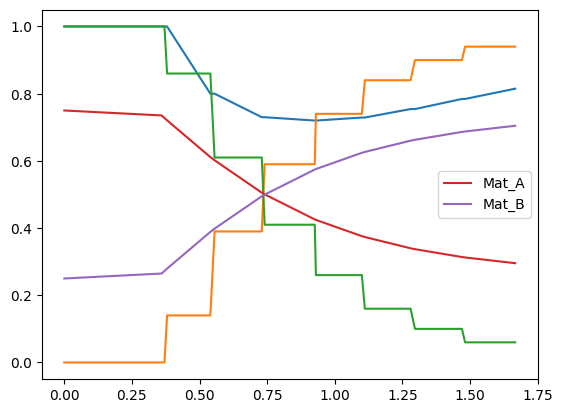

In [48]:
time = np.array([0, 0.36, 0.37037, 0.38, 0.54, 0.55556, 0.73, 0.74071, 0.925926, 0.93, 1.1, 1.111, 1.28, 1.2963, 1.47, 1.48148, 1.6667])
rate = [79312, 79312, 79312, 79312, 63450, 63450, 57898, 57898, 57105, 57105, 57818, 57818, 59820, 59820, 62206, 62206, 64626]
ratioA = [0, 0, 0, 0.14, 0.14, 0.39, 0.39, 0.59, 0.59, 0.74, 0.74, 0.84, 0.84, 0.9, 0.9, 0.94, 0.94]
ratioB = [1, 1, 1, 0.86, 0.86, 0.61, 0.61, 0.41, 0.41, 0.26, 0.26, 0.16, 0.16, 0.1, 0.1, 0.06, 0.06]
plt.plot(time, rate/np.max(rate))
plt.plot(time, ratioA)
plt.plot(time, ratioB)
level_1 = 0.75
level_2 = 0.25
#offset parameters
signal1_offset = -1.2
signal2_offset = -1.1
#rise parameters
tau_rise = 0.88
del_rise = 1.54 + signal1_offset
#drop parameters
tau_drop = 0.4
del_drop = 1.44 + signal2_offset
time_sample = np.linspace(0,time[-1],5000)
drop_ind = (np.abs(time_sample - del_drop)).argmin()
rise_ind = (np.abs(time_sample - del_rise)).argmin()
if level_1 < level_2:
    mat_A_sample = np.exp(-((time_sample - del_rise)/tau_rise))*level_1 + (1 - np.exp(-((time_sample - del_rise)/tau_rise)))*level_2
    mat_A_sample[:rise_ind] = level_1
    mat_B_sample = np.exp(-((time_sample-del_drop)/tau_drop))*(1-level_1) + (1 - np.exp(-((time_sample-del_drop)/tau_drop)))*(1-level_2)
    mat_B_sample[:drop_ind] = (1-level_1)
else:
    mat_A_sample = np.exp(-((time_sample-del_drop)/tau_drop))*level_1 + (1 - np.exp(-((time_sample-del_drop)/tau_drop)))*level_2
    mat_A_sample[:drop_ind] = level_1
    mat_B_sample = np.exp(-((time_sample-del_rise)/tau_rise))*(1-level_1) + (1 - np.exp(-((time_sample-del_rise)/tau_rise)))*(1-level_2)
    mat_B_sample[:rise_ind] = (1-level_1)

sample_ind = np.zeros(len(time),dtype=int)
for i in range(len(time)):
    sample_ind[i] = (np.abs(time[i] - time_sample)).argmin()
    print(sample_ind[i])

mat_A = mat_A_sample[sample_ind]
mat_B = mat_B_sample[sample_ind]
plt.plot(time, mat_A/(mat_A + mat_B),label='Mat_A')
plt.plot(time, mat_B/(mat_A + mat_B),label='Mat_B')
plt.legend()

In [ ]:
preamble = ["\n    np_liquid=1,",
            "    ipliquid_nmax=500000, remark='Maximum number of liquid particles',",
            "    ipliquid_species=2,\n",
            "    pliquid_species_title(1)='Liquid Species 1', remark='Species title',",
            "    pliquid_species_diameter(1)=0.006, remark='Particle Diameter',\n",
            "    pliquid_species_title(2)='Liquid Species 2', remark='Species title',",
            "    pliquid_species_diameter(2)=0.006, remark='Particle Diameter',\n\n",
            "    ippkt=8,\n"]

mass_flow = (mat_A+mat_B)*rate[0]
total_lines = preamble
total_source = 8
for source_i in range(1,total_source+1):
    body_i = [f"    if_psource_enabled({source_i})=1,",
            f"    ParticleSourceName({source_i})='Source_{source_i}', remark='Particle Source Name',",
            f"    isrc_class({source_i})=13, remark='Particle Source Class',",
            f"    xppl({source_i})=-0.217, remark='X low',",
            f"    xppr({source_i})=-0.183, remark='X high',",
            f"    yppf({source_i})=-0.617, remark='Y low',",
            f"    yppbk({source_i})=-0.583, remark='Y high',",
            f"    zppb({source_i})=0.30, remark='Z low',",
            f"    zppt({source_i})=0.35, remark='Z high',"
            f"    upp({source_i})=0.0, remark='X velocity',",
            f"    vpp({source_i})=0.0, remark='Y velocity',",
            f"    wpp({source_i})=-400, remark='Z velocity',",
            "    remark= 'Rate of generation',"]
    mid_line = f"    src_temperature({source_i})=298, remark='Initial temperature',"
    if source_i == 1:
        body_rate_i = [f"    ratet(1,1)={np.round(mass_flow[0],1)},",
                    f"    ratet(3,1)={np.round(mass_flow[2],1)},",
                    f"    ratet(4,1)=0.0,",
                    mid_line,
                    f"    src_species(1, 1)={np.round(mat_A[0],4)},",
                    f"    src_species(2, 1)={np.round(mat_B[0],4)},\n"]
    elif source_i == total_source:
        body_rate_i = ["    ratet(1,8)=0.0,",
                    "    ratet(15,8)=0.0,",
                    f"    ratet(16,8)={np.round(mass_flow[2*total_source - 1],2)},",
                    f"    ratet(17,8)={np.round(mass_flow[2*total_source],2)},",
                    mid_line,
                    f"    src_species(1, 8)={np.round(np.mean((mat_A/(mat_A + mat_B))[(2*total_source - 1):]),4)},",
                    f"    src_species(2, 8)={np.round(np.mean((mat_B/(mat_A + mat_B))[(2*total_source - 1):]),4)},\n"]
    else:
        body_rate_i = ["    ratet(1,4)=0.0,",
                    f"    ratet({2*source_i - 1},{source_i})=0.0,",
                    f"    ratet({2*source_i},{source_i})={np.round(mass_flow[2*source_i],2)},",
                    f"    ratet({2*source_i + 1},{source_i})={np.round(mass_flow[2*source_i + 1],2)},",
                    f"    ratet({2*(source_i + 1)},{source_i})=0.0,",
                    mid_line,
                    f"    src_species(1, {source_i})={np.round(np.mean((mat_A/(mat_A + mat_B))[(2*source_i - 1):(2*source_i + 1)]),4)},",
                    f"    src_species(2, {source_i})={np.round(np.mean((mat_B/(mat_A + mat_B))[(2*source_i - 1):(2*source_i + 1)]),4)},\n"]
    
    total_lines = total_lines + body_i + body_rate_i

for time_i in range(1, len(time)+1):
    total_lines = total_lines + [f"    tms({time_i})={time[time_i-1]},"]
total_lines = total_lines + ["\n"]
for line in total_lines:
    print(line)



    np_liquid=1,
    ipliquid_nmax=500000, remark='Maximum number of liquid particles',
    ipliquid_species=2,

    pliquid_species_title(1)='Liquid Species 1', remark='Species title',
    pliquid_species_diameter(1)=0.006, remark='Particle Diameter',

    pliquid_species_title(2)='Liquid Species 2', remark='Species title',
    pliquid_species_diameter(2)=0.006, remark='Particle Diameter',


    ippkt=8,

    if_psource_enabled(1)=1,
    ParticleSourceName(1)='Source_1', remark='Particle Source Name',
    isrc_class(1)=13, remark='Particle Source Class',
    xppl(1)=-0.217, remark='X low',
    xppr(1)=-0.183, remark='X high',
    yppf(1)=-0.617, remark='Y low',
    yppbk(1)=-0.583, remark='Y high',
    zppb(1)=0.30, remark='Z low',
    zppt(1)=0.35, remark='Z high',    upp(1)=0.0, remark='X velocity',
    vpp(1)=0.0, remark='Y velocity',
    wpp(1)=-400, remark='Z velocity',
    remark= 'Rate of generation',
    ratet(1,1)=79312.0,
    ratet(3,1)=76203.6,
    ratet(4,1)=0.0,
    src_

In [37]:
f = open(r"C:\Users\broke\Downloads\prepin.10_Exercise",'r')
replace_section = False
part_num = 1
part_1 = []
part_2 = []
for line in f:
    if len(line) > 1:
        line = line[:-1]
    if replace_section and "/" in line:
        replace_section = False
        part_num = 2
    if replace_section == False:
        if part_num == 1:
            part_1 = part_1 + [line]
        else:
            part_2 = part_2 + [line]
    if "&parts" in line:
        replace_section = True

f.close()
total_file = part_1 + total_lines + part_2